# ***Project Time Series Audio Dataset***

In [1]:
import os
import pandas as pd
import librosa
import warnings

import tsfel
from tqdm import tqdm

import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import joblib

## **Membaca Dataset**

In [2]:
# -- Mengabaikan peringatan dari librosa terkait format non-wav --
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

# Konfigurasi Path dan Label 
dataset_path = 'dataset/audio' 

labels = ['buka', 'tutup']  


In [3]:
# -- Proses Pemuatan Data --
data_list = []

print("Memulai proses pembacaan file audio...")

# Looping untuk setiap label (folder 'buka' dan 'tutup')
for label in labels:
    label_path = os.path.join(dataset_path, label)
    
    # Memastikan folder ada sebelum melanjutkan
    if not os.path.exists(label_path):
        print(f"Peringatan: Folder untuk label '{label}' tidak ditemukan di '{label_path}'")
        continue

    print(f"Membaca file dari folder: {label_path}")
    
    # Looping untuk setiap file di dalam folder label
    for filename in os.listdir(label_path):
        if filename.endswith('.aac'):
            file_path = os.path.join(label_path, filename)
            
            try:
                # librosa.load akan membaca file audio dan mengubahnya menjadi:
                # 1. audio_signal: Array NumPy yang merepresentasikan gelombang suara.
                # 2. sr: Sampling rate dari audio tersebut (jumlah sampel per detik).
                # sr=None berarti kita akan menggunakan sampling rate asli dari file audio.
                audio_signal, sr = librosa.load(file_path, sr=None)
                
                # Tambahkan data yang sudah dibaca ke dalam list
                data_list.append({
                    'filename': filename,
                    'audio_signal': audio_signal,
                    'sampling_rate': sr,
                    'label': label
                })
            except Exception as e:
                # Memberi tahu jika ada file yang gagal dibaca
                print(f"Error saat membaca file {file_path}: {e}")

print("Proses pembacaan data selesai.")

Memulai proses pembacaan file audio...
Membaca file dari folder: dataset/audio\buka


C:\Users\MyBook Z Series\AppData\Local\Temp\ipykernel_12108\2445009650.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, sr = librosa.load(file_path, sr=None)
d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py3.11\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\MyBook Z Series\AppData\Local\Temp\ipykernel_12108\2445009650.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, sr = librosa.load(file_path, sr=None)
d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py3.11\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Membaca file dari folder: dataset/audio\tutup
Proses pembacaan data selesai.


In [4]:
# -- Konversi ke Pandas DataFrame --
df = pd.DataFrame(data_list)

# -- Verifikasi Hasil --
if not df.empty:
    print("\n--- Ringkasan Dataset ---")
    print(f"Total file yang berhasil dibaca: {len(df)}")
    
    # Menampilkan 5 baris pertama dari DataFrame
    print("\nContoh 5 data pertama:")
    print(df.head())
    
    # Menampilkan informasi detail tentang DataFrame (tipe data, memori, dll)
    print("\nInformasi DataFrame:")
    df.info()
    
    # Menampilkan jumlah data untuk setiap label untuk memastikan data seimbang
    print("\nJumlah data per label:")
    print(df['label'].value_counts())
else:
    print("\nTidak ada data yang berhasil dibaca. Pastikan path dan nama file sudah benar.")


--- Ringkasan Dataset ---
Total file yang berhasil dibaca: 200

Contoh 5 data pertama:
              filename                                       audio_signal  \
0  20251030_183541.aac  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  20251030_183623.aac  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  20251030_183635.aac  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  20251030_183717.aac  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  20251030_183723.aac  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

   sampling_rate label  
0          44100  buka  
1          44100  buka  
2          44100  buka  
3          44100  buka  
4          44100  buka  

Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       200 non-null    object
 1   audio_signal   200 non-null    object
 

## **Ekstraksi Fitur**

In [5]:
# -- Persiapan Ekstraksi Fitur ---

# Mengecek apakah DataFrame memiliki data
if not df.empty:
    print("\nMemulai proses ekstraksi fitur dengan TSFEL...")

    try:
        cfg = tsfel.get_features_by_domain()
    except FileNotFoundError:
        print("File konfigurasi default tidak ditemukan, coba inisialisasi TSFEL.")
        # Jika ada error, kadang perlu inisialisasi seperti ini
        tsfel.get_features_by_domain('statistical') 
        cfg = tsfel.get_features_by_domain()


    # Siapkan list kosong untuk menampung hasil ekstraksi fitur dari setiap file
    all_features = []

    # Looping melalui setiap baris di DataFrame Anda
    # tqdm akan memberikan visualisasi progress bar yang bagus
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        # Ambil sinyal audio dan sampling rate dari baris saat ini
        signal = row['audio_signal']
        sr = row['sampling_rate']
        
        # Ekstrak fitur menggunakan tsfel Fungsi ini akan mengembalikan satu baris DataFrame yang berisi puluhan fitur
        features = tsfel.time_series_features_extractor(cfg, signal, fs=sr, verbose=0)
        
        # Tambahkan hasil fitur ke dalam list
        all_features.append(features)

    # --- Membuat DataFrame Fitur ---

    # Menggabungkan semua hasil fitur (yang masing-masing adalah DataFrame 1 baris) menjadi satu DataFrame besar.
    features_df = pd.concat(all_features, ignore_index=True)

    # Menambahkan kolom 'label' dari DataFrame asli ke DataFrame fitur
    # Pastikan urutannya tetap sama
    features_df['label'] = df['label']

    print("\nProses ekstraksi fitur selesai.")

    # --- Verifikasi Hasil Ekstraksi ---
    print("\n--- Ringkasan DataFrame Fitur ---")
    print(f"Jumlah baris (sampel): {features_df.shape[0]}")
    print(f"Jumlah kolom (fitur + label): {features_df.shape[1]}")

    print("\nContoh 5 data pertama dari DataFrame Fitur:")
    # Menampilkan 5 baris pertama dan 5 kolom fitur pertama agar tidak terlalu lebar
    print(features_df.iloc[:, :5].head()) 
    
else:
    print("\nDataFrame awal kosong, proses ekstraksi fitur dilewati.")


Memulai proses ekstraksi fitur dengan TSFEL...


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:49<00:00,  1.18it/s]


Proses ekstraksi fitur selesai.

--- Ringkasan DataFrame Fitur ---
Jumlah baris (sampel): 200
Jumlah kolom (fitur + label): 157

Contoh 5 data pertama dari DataFrame Fitur:
   0_Absolute energy  0_Area under the curve  0_Autocorrelation  \
0         990.102982                0.089328               13.0   
1         702.588011                0.069497               13.0   
2         666.529384                0.099788               12.0   
3         482.823340                0.062194               17.0   
4        1261.127433                0.130005               13.0   

   0_Average power  0_Centroid  
0       576.226216    1.150631  
1       530.850160    0.885468  
2       239.210490    1.525034  
3       266.586237    1.351923  
4       764.971456    1.023790  


## **Seleksi Fitur**

### *Show Top 20 Feature With 2 Method*

In [6]:
# --- Persiapan Data untuk Seleksi Fitur ---
print("\n--- Mempersiapkan Data untuk Seleksi Fitur ---")

# Menghapus kolom yang mungkin mengandung nilai NaN (Not a Number) atau Infinity
features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
features_df.dropna(axis=1, inplace=True) # Menghapus kolom jika ada NaN

# Memisahkan antara fitur (X) dan label (y)
X = features_df.drop('label', axis=1)
y_text = features_df['label']

# Label Encoding: Mengubah label teks ('buka', 'tutup') menjadi angka (0, 1)
le = LabelEncoder()
y = le.fit_transform(y_text)
print(f"Label '{le.classes_[0]}' diubah menjadi 0, dan '{le.classes_[1]}' diubah menjadi 1.")

# Feature Scaling: Menyamakan rentang nilai semua fitur antara 0 dan 1.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Data siap untuk seleksi fitur.")


--- Mempersiapkan Data untuk Seleksi Fitur ---
Label 'buka' diubah menjadi 0, dan 'tutup' diubah menjadi 1.
Data siap untuk seleksi fitur.


In [7]:
# --- Metode 1: ANOVA F-test dengan SelectKBest ---
# antara nilai rata-rata suatu fitur untuk kelas 'buka' dan 'tutup'.

print("\n--- METODE 1: Seleksi Fitur dengan ANOVA F-test (SelectKBest) ---")

# Menentukan jumlah fitur terbaik yang ingin kita pilih (misalnya 20)
k_best = 20
selector_kbest = SelectKBest(score_func=f_classif, k=k_best)

# Menjalankan proses seleksi pada data
selector_kbest.fit(X_scaled, y)

# Mendapatkan nama-nama kolom dari fitur yang terpilih
selected_features_kbest = X.columns[selector_kbest.get_support()]

print(f"\n{k_best} Fitur Terbaik menurut SelectKBest:")

for feature in list(selected_features_kbest):
    print(f"- {feature}")


--- METODE 1: Seleksi Fitur dengan ANOVA F-test (SelectKBest) ---

20 Fitur Terbaik menurut SelectKBest:
- 0_Autocorrelation
- 0_Median frequency
- 0_Power bandwidth
- 0_Spectral entropy
- 0_Wavelet energy_1575.0Hz
- 0_Wavelet energy_1837.5Hz
- 0_Wavelet energy_2205.0Hz
- 0_Wavelet energy_2756.25Hz
- 0_Wavelet energy_3675.0Hz
- 0_Wavelet standard deviation_1575.0Hz
- 0_Wavelet standard deviation_1837.5Hz
- 0_Wavelet standard deviation_2205.0Hz
- 0_Wavelet standard deviation_2756.25Hz
- 0_Wavelet standard deviation_3675.0Hz
- 0_Wavelet variance_1378.12Hz
- 0_Wavelet variance_1575.0Hz
- 0_Wavelet variance_1837.5Hz
- 0_Wavelet variance_2205.0Hz
- 0_Wavelet variance_2756.25Hz
- 0_Wavelet variance_3675.0Hz


d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py3.11\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [37 38 39 40 41 42 43 44 45 46 47 48] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py3.11\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [8]:
# --- Metode 2: Feature Importance dari Random Forest ---
print("\n--- METODE 2: Seleksi Fitur dengan Random Forest Importance ---")

# Inisialisasi model RandomForestClassifier
# n_estimators=100 berarti model ini terdiri dari 100 'pohon keputusan'
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_scaled, y)

# Mendapatkan skor 'kepentingan' dari setiap fitur
importances = rf_model.feature_importances_

# Membuat DataFrame untuk menampilkan fitur dan skor kepentingannya
feature_importance_df = pd.DataFrame({
    'Fitur': X.columns,
    'Skor_Kepentingan': importances
}).sort_values(by='Skor_Kepentingan', ascending=False) # Urutkan dari yang terpenting

# Mengambil 20 fitur teratas
top_20_features_rf = feature_importance_df.head(20)

print(f"\n20 Fitur Paling Penting menurut Random Forest:")
print(top_20_features_rf)


--- METODE 2: Seleksi Fitur dengan Random Forest Importance ---

20 Fitur Paling Penting menurut Random Forest:
                                         Fitur  Skor_Kepentingan
60                          0_Median frequency          0.052391
66                           0_Power bandwidth          0.038381
153                0_Wavelet variance_3675.0Hz          0.033402
74                          0_Spectral entropy          0.032290
2                            0_Autocorrelation          0.025198
133                 0_Wavelet energy_2756.25Hz          0.022155
152               0_Wavelet variance_2756.25Hz          0.021122
75                         0_Spectral kurtosis          0.019190
144      0_Wavelet standard deviation_3675.0Hz          0.018715
49                                       0_Max          0.018597
79                         0_Spectral skewness          0.016322
150                0_Wavelet variance_1837.5Hz          0.016148
69                                  0_Skew

### *Using Top 20 Feature*

In [9]:
# --- Menggabungkan Hasil dari Dua Metode Seleksi ---

print("\n--- Menggabungkan Hasil Seleksi Fitur ---")

set_kbest = set(selected_features_kbest)
set_rf = set(top_20_features_rf['Fitur'])

# Menemukan irisan (fitur yang ada di kedua set) menggunakan operator '&'
common_features = set_kbest.intersection(set_rf)

# Mengubah kembali ke dalam bentuk list agar mudah dibaca
common_features_list = list(common_features)

print(f"\nJumlah fitur yang dipilih oleh SelectKBest: {len(set_kbest)}")
print(f"Jumlah fitur yang dipilih oleh Random Forest: {len(set_rf)}")
print(f"Jumlah fitur yang sama (irisan): {len(common_features_list)}")  

if len(common_features_list) > 0:
    print("\nFitur-fitur yang dianggap penting oleh KEDUA metode adalah:")
    # Mencetak daftar fitur gabungan
    for feature in common_features_list:
        print(f"- {feature}")
else:
    print("\nTidak ditemukan fitur yang sama antara kedua metode. Anda mungkin bisa mempertimbangkan:")
    print("1. Meningkatkan jumlah fitur yang dipilih (misal, `k=30` di SelectKBest).")
    print("2. Menggunakan daftar fitur dari Random Forest saja, karena seringkali lebih andal.")


--- Menggabungkan Hasil Seleksi Fitur ---

Jumlah fitur yang dipilih oleh SelectKBest: 20
Jumlah fitur yang dipilih oleh Random Forest: 20
Jumlah fitur yang sama (irisan): 11

Fitur-fitur yang dianggap penting oleh KEDUA metode adalah:
- 0_Wavelet energy_1837.5Hz
- 0_Power bandwidth
- 0_Wavelet energy_3675.0Hz
- 0_Wavelet variance_2756.25Hz
- 0_Wavelet variance_3675.0Hz
- 0_Median frequency
- 0_Wavelet standard deviation_3675.0Hz
- 0_Spectral entropy
- 0_Autocorrelation
- 0_Wavelet energy_2756.25Hz
- 0_Wavelet variance_1837.5Hz


In [10]:
# Jalankan ini di skrip PELATIHAN Anda
# untuk mendapatkan daftar fitur yang benar

if 'common_features_list' in locals() and len(common_features_list) > 0:
    print("Daftar Fitur Gabungan (Terbaik):")
    print(common_features_list)
else:
    print("Daftar Fitur dari Random Forest (Gunakan ini jika tidak ada gabungan):")
    # Mengambil daftar dari DataFrame feature_importance_df
    rf_feature_list = list(top_20_features_rf['Fitur'])
    print(rf_feature_list)

Daftar Fitur Gabungan (Terbaik):
['0_Wavelet energy_1837.5Hz', '0_Power bandwidth', '0_Wavelet energy_3675.0Hz', '0_Wavelet variance_2756.25Hz', '0_Wavelet variance_3675.0Hz', '0_Median frequency', '0_Wavelet standard deviation_3675.0Hz', '0_Spectral entropy', '0_Autocorrelation', '0_Wavelet energy_2756.25Hz', '0_Wavelet variance_1837.5Hz']


In [11]:
# --- Membuat DataFrame Final dengan Fitur Gabungan ---
if len(common_features_list) > 0:
    final_features_df = features_df[common_features_list + ['label']]
    
    print("\nDataFrame final dengan fitur gabungan telah dibuat.")
    print("Dimensi DataFrame Final:", final_features_df.shape)
    print("\nContoh 5 baris pertama DataFrame Final:")
    print(final_features_df.head())


DataFrame final dengan fitur gabungan telah dibuat.
Dimensi DataFrame Final: (200, 12)

Contoh 5 baris pertama DataFrame Final:
   0_Wavelet energy_1837.5Hz  0_Power bandwidth  0_Wavelet energy_3675.0Hz  \
0                   0.204840        1319.345175                   0.057291   
1                   0.187202        1319.192023                   0.061736   
2                   0.135893        1206.936035                   0.036851   
3                   0.088876         505.202073                   0.021203   
4                   0.211342         666.012874                   0.049080   

   0_Wavelet variance_2756.25Hz  0_Wavelet variance_3675.0Hz  \
0                      0.010410                     0.003282   
1                      0.009466                     0.003811   
2                      0.004304                     0.001358   
3                      0.001452                     0.000450   
4                      0.008296                     0.002409   

   0_Median frequ

In [12]:
# --- Memisahkan Fitur (X) dan Label (y) dari DataFrame Final ---

if 'common_features_list' in locals() and len(common_features_list) > 0:
    # Jika ada fitur gabungan, gunakan DataFrame final
    df_for_split = final_features_df
    print("Menggunakan DataFrame dengan fitur gabungan untuk pembagian data.")
else:
    # Jika tidak, gunakan DataFrame dengan semua fitur sebagai fallback
    df_for_split = features_df
    print("Peringatan: Menggunakan DataFrame dengan SEMUA fitur untuk pembagian data.")

# X adalah semua kolom kecuali 'label' (ini adalah fitur-fitur kita)
X = df_for_split.drop('label', axis=1)

# y adalah hanya kolom 'label' (ini adalah target yang ingin kita prediksi)
y = df_for_split['label']

Menggunakan DataFrame dengan fitur gabungan untuk pembagian data.


In [13]:
# --- Melakukan Pembagian Data ---

print("\nMelakukan pembagian data menjadi 80% data latih dan 20% data uji...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


# --- 16. Verifikasi Hasil Pembagian ---
print("\nPembagian data selesai. Berikut adalah ringkasannya:")
print(f"Jumlah data latih (X_train): {X_train.shape[0]} sampel")
print(f"Jumlah data uji (X_test):   {X_test.shape[0]} sampel")
print("-" * 30)
print("Distribusi label pada data latih (y_train):")
print(y_train.value_counts())
print("\nDistribusi label pada data uji (y_test):")
print(y_test.value_counts())


Melakukan pembagian data menjadi 80% data latih dan 20% data uji...

Pembagian data selesai. Berikut adalah ringkasannya:
Jumlah data latih (X_train): 160 sampel
Jumlah data uji (X_test):   40 sampel
------------------------------
Distribusi label pada data latih (y_train):
label
buka     80
tutup    80
Name: count, dtype: int64

Distribusi label pada data uji (y_test):
label
buka     20
tutup    20
Name: count, dtype: int64


## **Normalisasi**

In [14]:
from sklearn.preprocessing import MinMaxScaler

# --- Normalisasi (Scaling) Data ---

print("Melakukan normalisasi (Min-Max Scaling) pada data...")

# 1. Buat objek scaler
scaler = MinMaxScaler()

# 2. Latih scaler HANYA pada data latih (X_train) dan langsung transformasikan
# Ini seperti membuat "rangkuman" dari data latihan
X_train_scaled = scaler.fit_transform(X_train)

# 3. Gunakan scaler yang SUDAH DILATIH untuk mentransformasi data uji (X_test)
# Jangan gunakan .fit_transform() lagi, cukup .transform()!
X_test_scaled = scaler.transform(X_test)

# --- Konversi Kembali ke DataFrame ---
# Hasil dari scaler adalah array NumPy. Mengubahnya kembali ke DataFrame membantu menjaga nama kolom dan keterbacaan.

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nNormalisasi selesai. Semua nilai fitur sekarang berada di antara 0 dan 1.")
print("\nContoh 5 baris pertama dari X_train yang sudah dinormalisasi:")
print(X_train_scaled.head())

Melakukan normalisasi (Min-Max Scaling) pada data...

Normalisasi selesai. Semua nilai fitur sekarang berada di antara 0 dan 1.

Contoh 5 baris pertama dari X_train yang sudah dinormalisasi:
   0_Wavelet energy_1837.5Hz  0_Power bandwidth  0_Wavelet energy_3675.0Hz  \
0                   0.030544           0.264705                   0.011696   
1                   0.321669           0.114020                   0.212816   
2                   0.417170           0.200880                   0.347024   
3                   0.021699           0.079773                   0.020037   
4                   0.006126           0.082659                   0.021406   

   0_Wavelet variance_2756.25Hz  0_Wavelet variance_3675.0Hz  \
0                      0.001915                     0.001114   
1                      0.086115                     0.059457   
2                      0.164012                     0.139588   
3                      0.001453                     0.002062   
4                   

## **Modeling**

In [15]:
# --- Inisialisasi Model-model Klasifikasi ---

# Kita akan menyiapkan tiga model yang berbeda
models = {
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (SVM)": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Siapkan dictionary untuk menyimpan hasil performa setiap model
results = {}

--- Memulai Pelatihan dan Evaluasi Model ---



========== Melatih Model: K-Nearest Neighbors (KNN) ==========
Model berhasil dilatih.
Prediksi pada data uji selesai.

Akurasi: 0.8500 (85.00%)

Laporan Klasifikasi:
              precision    recall  f1-score   support

        buka       0.82      0.90      0.86        20
       tutup       0.89      0.80      0.84        20

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

Menampilkan Confusion Matrix...


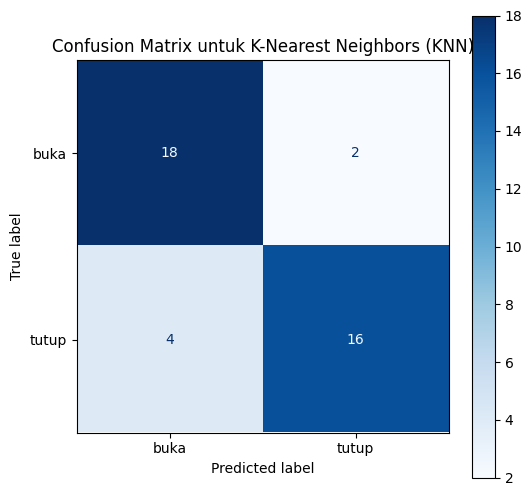


========== Melatih Model: Support Vector Machine (SVM) ==========
Model berhasil dilatih.
Prediksi pada data uji selesai.

Akurasi: 0.8500 (85.00%)

Laporan Klasifikasi:
              precision    recall  f1-score   support

        buka       0.89      0.80      0.84        20
       tutup       0.82      0.90      0.86        20

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

Menampilkan Confusion Matrix...


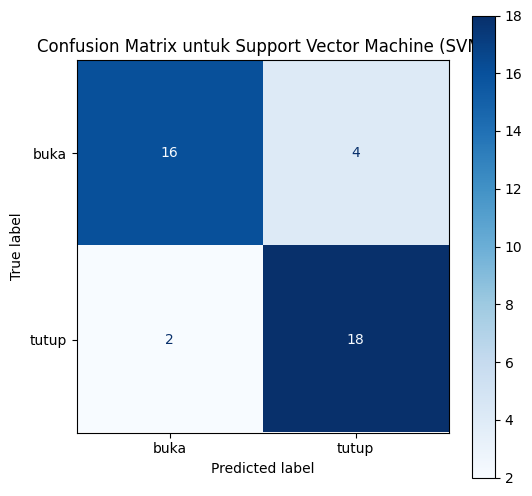


========== Melatih Model: Random Forest ==========
Model berhasil dilatih.
Prediksi pada data uji selesai.

Akurasi: 0.9000 (90.00%)

Laporan Klasifikasi:
              precision    recall  f1-score   support

        buka       0.86      0.95      0.90        20
       tutup       0.94      0.85      0.89        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

Menampilkan Confusion Matrix...


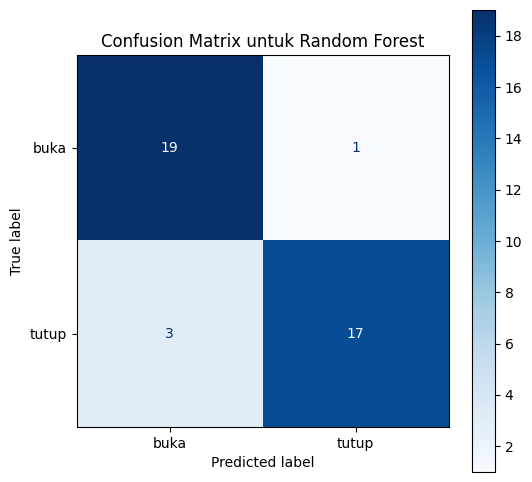

In [16]:
# --- 20. Proses Pelatihan dan Evaluasi ---

print("--- Memulai Pelatihan dan Evaluasi Model ---")

# Looping untuk setiap model yang sudah kita siapkan
for model_name, model in models.items():
    print(f"\n{'='*10} Melatih Model: {model_name} {'='*10}")
    
    # 1. Latih model menggunakan data latih yang sudah dinormalisasi
    model.fit(X_train_scaled, y_train)
    print("Model berhasil dilatih.")
    
    # 2. Lakukan prediksi pada data uji
    y_pred = model.predict(X_test_scaled)
    print("Prediksi pada data uji selesai.")
    
    # 3. Hitung akurasi
    # Akurasi = (Jumlah prediksi benar / Total data uji) * 100%
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    
    # 4. Tampilkan laporan klasifikasi yang detail
    # Laporan ini menunjukkan precision, recall, dan f1-score untuk setiap kelas
    print(f"\nAkurasi: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\nLaporan Klasifikasi:")
    # 'target_names' digunakan untuk menampilkan nama label asli ('buka', 'tutup')
    # Pastikan variabel 'le' dari langkah LabelEncoder masih ada
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)
    
    # 5. Tampilkan Confusion Matrix
    # Ini adalah cara visual untuk melihat performa model
    # Sumbu Y: Kelas Sebenarnya (True Label)
    # Sumbu X: Kelas Prediksi (Predicted Label)
    print("Menampilkan Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(
        model, 
        X_test_scaled, 
        y_test, 
        display_labels=le.classes_, 
        cmap='Blues',
        ax=ax
    )
    ax.set_title(f"Confusion Matrix untuk {model_name}")
    plt.show()


========== Ringkasan Performa Model ==========
                          Model  Akurasi
2                 Random Forest     0.90
0     K-Nearest Neighbors (KNN)     0.85
1  Support Vector Machine (SVM)     0.85


C:\Users\MyBook Z Series\AppData\Local\Temp\ipykernel_12108\4041141611.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Akurasi', y='Model', data=results_df, palette='viridis')


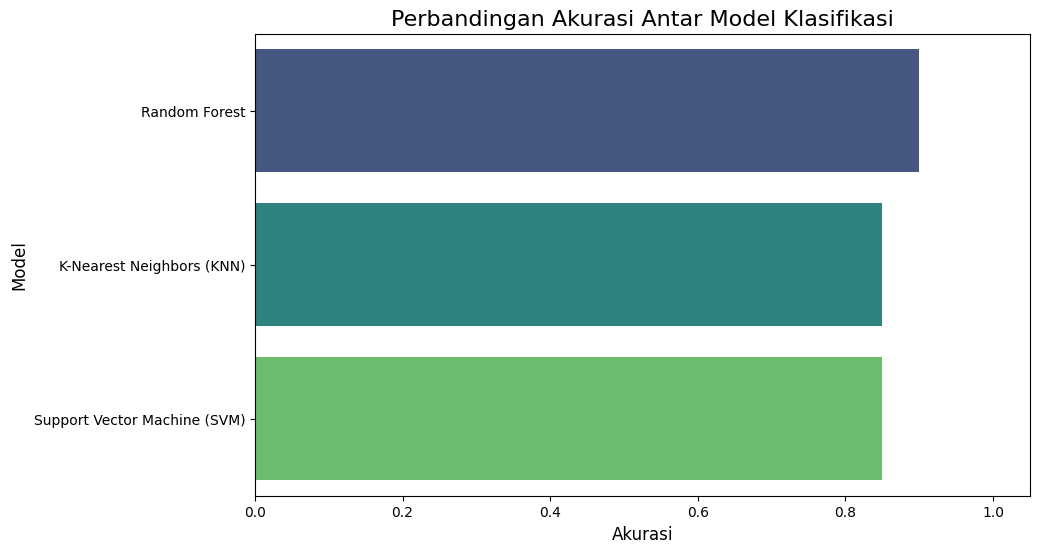

In [17]:
# --- 21. Perbandingan Hasil Akhir ---

print(f"\n{'='*10} Ringkasan Performa Model {'='*10}")
# Mengubah hasil ke dalam DataFrame untuk tampilan yang rapi
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Akurasi'])
results_df = results_df.sort_values(by='Akurasi', ascending=False)

print(results_df)

# Visualisasi perbandingan akurasi
plt.figure(figsize=(10, 6))
sns.barplot(x='Akurasi', y='Model', data=results_df, palette='viridis')
plt.title('Perbandingan Akurasi Antar Model Klasifikasi', fontsize=16)
plt.xlabel('Akurasi', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.05) # Batas sumbu x dari 0 sampai 1.05 untuk spasi
plt.show()

In [18]:
# # --- Menyimpan Model Terbaik dan Scaler ---

# print("\n--- Menyimpan Model dan Scaler ---")

# # Tentukan model terbaik dari dictionary 'models'
# best_model_name = "Random Forest"
# best_model = models[best_model_name]

# # Membuat folder untuk menyimpan model jika belum ada
# output_dir = 'saved_models'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     print(f"Folder '{output_dir}' berhasil dibuat.")

# # Tentukan path lengkap untuk menyimpan file
# model_path = os.path.join(output_dir, 'random_forest_model.joblib')
# scaler_path = os.path.join(output_dir, 'scaler.joblib')

# # 1. Menyimpan model Random Forest
# joblib.dump(best_model, model_path)
# print(f"Model '{best_model_name}' berhasil disimpan di: {model_path}")

# # 2. Menyimpan objek scaler
# # Pastikan variabel 'scaler' dari langkah normalisasi masih ada
# joblib.dump(scaler, scaler_path)
# print(f"Scaler berhasil disimpan di: {scaler_path}")